In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [27]:
data = pd.read_csv('../input/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
79517,00019530_012.png,No Finding,12,19530,40,M,AP,2500,2048,0.168,0.168,NaN,../input/images_009/images/00019530_012.png
74928,00018378_001.png,Infiltration,1,18378,45,M,PA,2992,2841,0.143,0.143,NaN,../input/images_008/images/00018378_001.png
107650,00029088_016.png,Effusion,16,29088,47,F,AP,3056,2544,0.139,0.139,NaN,../input/images_012/images/00029088_016.png


In [28]:
#data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))#remove for multiclass
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
92514,00023092_002.png,No Finding,2,23092,54,M,AP,3056,2544,0.139,0.139,NaN,../input/images_010/images/00023092_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3978,00001088_001.png,No Finding,1,1088,38,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00001088_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91856,00022899_022.png,Infiltration|Mass|Nodule|Pleural_Thickening,22,22899,60,M,PA,2992,2991,0.143,0.143,NaN,../input/images_010/images/00022899_022.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [29]:
data.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
42033,00010816_000.png,Pneumothorax,0,10816,47,F,PA,2544,3048,0.139,0.139,NaN,../input/images_005/images/00010816_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49133,00012468_000.png,No Finding,0,12468,27,F,PA,2992,2991,0.143,0.143,NaN,../input/images_006/images/00012468_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46484,00011877_008.png,No Finding,8,11877,54,F,AP,2500,2048,0.168,0.168,NaN,../input/images_006/images/00011877_008.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (15) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19891), ('Mass', 5779), ('No Finding', 60353), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


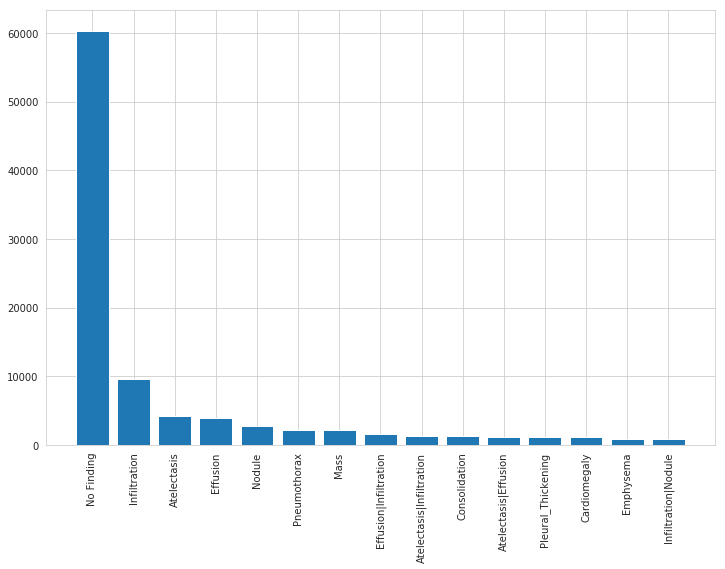

In [31]:
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(112104, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [32]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [33]:
#for multiclass only
#data['disease_vec'] = data.drop(sum(data['disease_vec'])>1, axis = 1)
data.drop(data[ (data['Atelectasis'] + data['Cardiomegaly'] + data['Consolidation'] + data['Edema'] + data['Effusion'] +
                 data['Emphysema'] + data['Fibrosis'] + data['Hernia'] + data['Infiltration'] + data['Mass'] +
                 data['No Finding'] + data['Nodule'] + data['Pleural_Thickening'] + data['Pneumonia']
                 + data['Pneumothorax']) > 1].index, inplace = True)

In [34]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 20,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 73049 test 18263


In [35]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 20,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 65744 valid 7305


In [36]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [37]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [38]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 65744 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7305 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 18263 images


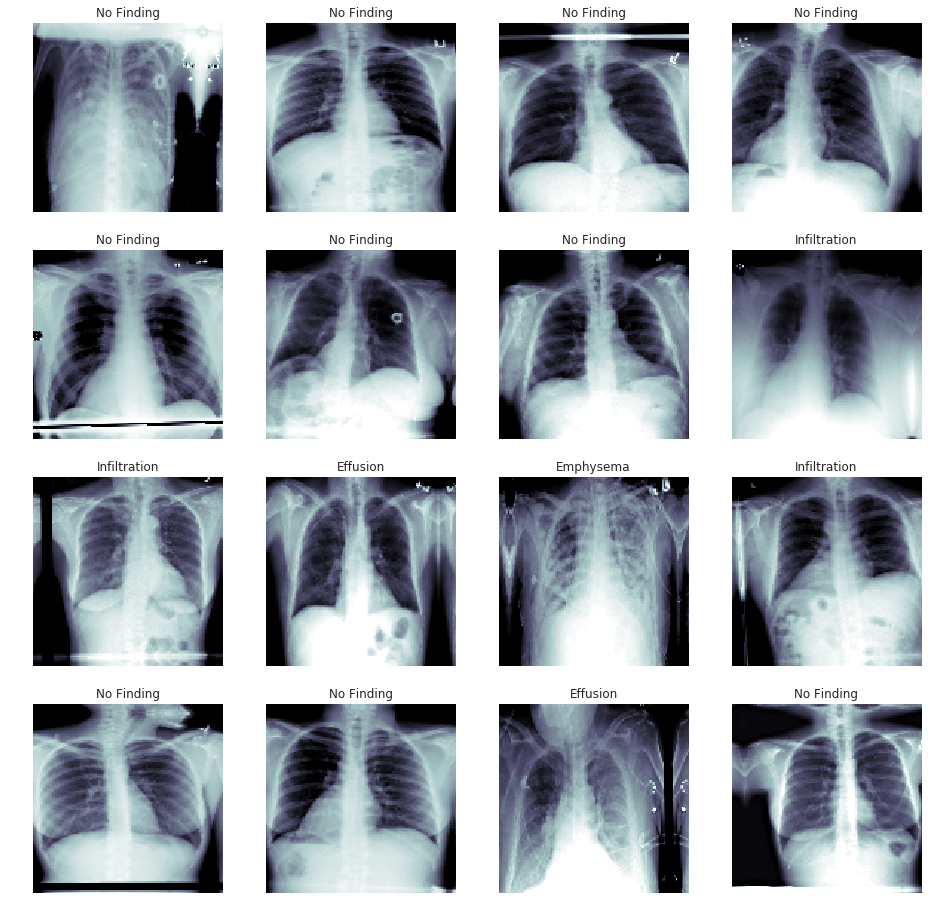

In [39]:

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [40]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [41]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'softmax'))#sigmoid
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=[precision_threshold(threshold = 0.5), 
                           recall_threshold(threshold = 0.5), 
                           fbeta_score_threshold(beta=0.5, threshold = 0.5),
                           fbeta_score_threshold(beta=1, threshold = 0.5),
                          'accuracy'])
multi_disease_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                7695      
Total params: 3,760,783
Trainable params: 3,738,895
Non-trainable params: 21,888
_____________________________________________________________

In [ ]:
##################################temporary

from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNetV2(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=[precision_threshold(threshold = 0.5), 
                           recall_threshold(threshold = 0.5), 
                           fbeta_score_threshold(beta=0.5, threshold = 0.5),
                          'accuracy'])
multi_disease_model.summary()


In [ ]:
valid_gen[3][1]

In [42]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  validation_steps = 20,
                                  epochs = 30)#30

Epoch 1/30
100/100 [==============================] - 57s 569ms/step - loss: 0.2321 - precision: 0.6017 - recall: 0.4706 - fbeta_score: 0.5623 - fbeta_score_1: 0.5198 - acc: 0.9451 - val_loss: 1.3628 - val_precision: 0.0250 - val_recall: 0.0250 - val_fbeta_score: 0.0250 - val_fbeta_score_1: 0.0250 - val_acc: 0.8700
Epoch 2/30
100/100 [==============================] - 49s 488ms/step - loss: 0.2270 - precision: 0.5948 - recall: 0.4500 - fbeta_score: 0.5466 - fbeta_score_1: 0.5002 - acc: 0.9436 - val_loss: 0.5712 - val_precision: 0.6625 - val_recall: 0.6625 - val_fbeta_score: 0.6625 - val_fbeta_score_1: 0.6625 - val_acc: 0.9550
Epoch 3/30
100/100 [==============================] - 49s 488ms/step - loss: 0.2061 - precision: 0.6299 - recall: 0.4906 - fbeta_score: 0.5908 - fbeta_score_1: 0.5457 - acc: 0.9467 - val_loss: 0.1302 - val_precision: 0.7000 - val_recall: 0.7000 - val_fbeta_score: 0.7000 - val_fbeta_score_1: 0.7000 - val_acc: 0.9600
Epoch 4/30
100/100 [=============================

Epoch 27/30
100/100 [==============================] - 51s 511ms/step - loss: 0.1329 - precision: 0.7077 - recall: 0.6119 - fbeta_score: 0.6843 - fbeta_score_1: 0.6538 - acc: 0.9571 - val_loss: 0.1491 - val_precision: 0.6792 - val_recall: 0.5656 - val_fbeta_score: 0.6511 - val_fbeta_score_1: 0.6148 - val_acc: 0.9529
Epoch 28/30
100/100 [==============================] - 50s 497ms/step - loss: 0.1395 - precision: 0.6821 - recall: 0.6156 - fbeta_score: 0.6666 - fbeta_score_1: 0.6458 - acc: 0.9551 - val_loss: 0.1309 - val_precision: 0.7200 - val_recall: 0.6000 - val_fbeta_score: 0.6908 - val_fbeta_score_1: 0.6526 - val_acc: 0.9577
Epoch 29/30
100/100 [==============================] - 50s 499ms/step - loss: 0.1453 - precision: 0.6740 - recall: 0.5519 - fbeta_score: 0.6427 - fbeta_score_1: 0.6034 - acc: 0.9521 - val_loss: 0.1345 - val_precision: 0.6777 - val_recall: 0.6750 - val_fbeta_score: 0.6771 - val_fbeta_score_1: 0.6763 - val_acc: 0.9569
Epoch 30/30
100/100 [=========================

In [45]:
score = multi_disease_model.evaluate(test_X, test_Y)
print('Test values:\n loss: ' ,score[0], '  precision: ', 
      score[1],'recall: ', score[2], ' fbeta_score: ',score[3],' fbeta_score_1: ',score[4],' acc: ', score[5])

1024/1024 [==============================] - 0s 454us/step
Test values:
 loss:  0.1390925976447761   precision:  0.6593458969146013 recall:  0.642578125  fbeta_score:  0.6558286054059863  fbeta_score_1:  0.6507124872878194  acc:  0.9540364816784859


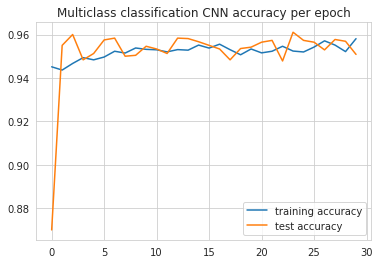

In [46]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='test accuracy')
plt.legend()
plt.title('Multiclass classification CNN accuracy per epoch')
plt.show()


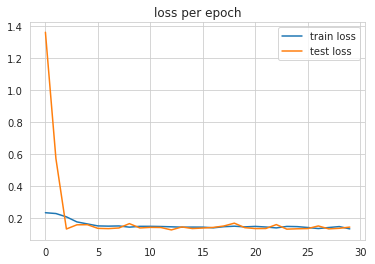

In [47]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.title('loss per epoch')
plt.show()

In [49]:
multi_disease_model.save("cnn_xray_multiclass_final.h5")

In [50]:
import tensorflow as tf
#model = Sequential(weights= "cnn_xray.h5")
#model.load_weights("cnn_xray.h5")
#new_model = tf.keras.models.load_model('cnn_xray_multiclass_final.h5')

ValueError: Unknown metric function:precision

In [ ]:
new_model.predict(test_X)

In [ ]:
#######################################new